## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Extract mae6292.zip
with zipfile.ZipFile('/Mae6292new.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Mae6292new')

# Verify extraction

print("Extracted files:", os.listdir('/content/Mae6292new'))

Extracted files: ['tools.py', '__init__.py', 'imshow.py']


In [ ]:
import sys
sys.path.append('/content/Mae6292new')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import Mae6292new.tools as mae6292
import importlib

from Mae6292new.imshow import cv2_imshow

(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

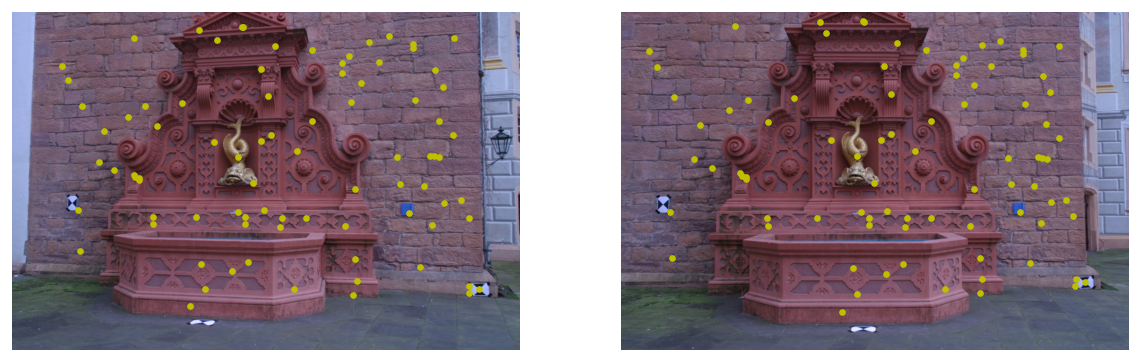

In [ ]:
# load images
img1 = cv2.imread('/0001.jpg')
img2 = cv2.imread('/0002.jpg')

# load intrinsic paramters
K = np.array([[1379.74, 0, 760.35],[0, 1382.08, 503.41], [0,0,1]])
K1 = K;
K2 = K;

# load matches keypoints
p1 = np.loadtxt('/matches0001.txt')
p2 = np.loadtxt('/matches0002.txt')
n = p1.shape[1]

p1 = np.concatenate( (p1, np.ones((1,n))), axis=0 )
p2 = np.concatenate( (p2, np.ones((1,n))), axis=0 )

# visualization
fig, axes = plt.subplots(1, 2, dpi=120, figsize=(12,6))
axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].plot(p1[0,:],p1[1,:],'y.')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].plot(p2[0,:],p2[1,:],'y.')
axes[1].axis('off')

Eight-Point Algorithm

For the given $p_1, p_2, K_1, K_2$, compute the essential matrix according to the following steps.

1. First, pixel coordinates are normalized by left-multiplying $K^{-1}$.
   Use [scipy.linalg.inv()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.inv.html)

2. Each row of $Q$ is given by $(\bar p_1^i \otimes \bar p_2^i)^T$. Use [np.kron()](https://numpy.org/doc/stable/reference/generated/numpy.kron.html)

3. Decompose $Q = US V^T$, and $\mathrm{vec}(E)$ corresponds to the last column of $V$. Use [scipy.linalg.svd()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html)

4. Reshape $\mathrm{vec}(E)$ into a 3 by 3 matrix $E$.  

And verity that
```
E=[[-2.32658231e-04 -2.30066653e-02 -1.38566261e-03]
 [ 1.61584860e-01  1.70952962e-03  6.90754078e-01]
 [-1.94754336e-03 -7.04422370e-01  5.14852933e-04]]
```

In [ ]:
# Normalizing pixel coordinates¹
p1_normalized = np.linalg.inv(K1) @ p1
p2_normalized = np.linalg.inv(K2) @ p2

Q = np.zeros((n, 9))
for i in range(n):
    Q[i, :] = np.kron(p1_normalized[:, i], p2_normalized[:, i])

# Computing SVD of Q
U, S, Vt = scipy.linalg.svd(Q)
E_vec = Vt[-1, :]
E = E_vec.reshape(3, 3)  # Reshaping

print("Essential matrix E:")
print(E)

Essential matrix E:
[[-2.32658231e-04  1.61584860e-01 -1.94754336e-03]
 [-2.30066653e-02  1.70952962e-03 -7.04422370e-01]
 [-1.38566261e-03  6.90754078e-01  5.14852933e-04]]


In [ ]:
def triangulation(p1, p2, M1, M2):

    assert p1.shape[0] == 3 and p2.shape[0] == 3
    assert p1.shape[1] == p2.shape[1]

    n = p1.shape[1]
    P = np.zeros((3, n))

    for i in range(n):

        A = np.vstack([
            mae6292.hat(p1[:, i]) @ M1,
            mae6292.hat(p2[:, i]) @ M2
        ])

        _, _, Vt = scipy.linalg.svd(A)
        P_homog = Vt[-1, :]

        # Converting to non-homogeneous coordinates
        P[:, i] = P_homog[:3] / P_homog[3]

    return P

Verify the above function with random data. Since we did not use any special structure of $M_1$ and $M_2$ in the above expression, they can be generated randomly. The following codes generate random inputs, and the resulting error is supposed to be at the order of $10^{-14}-10^{-15}$.

In [ ]:
n_test = 10
P_test = np.random.rand(4,n_test)
M1_test = np.random.rand(3,4)
M2_test = np.random.rand(3,4)
p1_test = M1_test@P_test
p2_test = M2_test@P_test

P_test_new = triangulation( p1_test, p2_test, M1_test, M2_test)

print('Recontrsuction error for P',scipy.linalg.norm(P_test[0:3,:]/P_test[3,:]-P_test_new))

Recontrsuction error for P 5.49556289526325e-14




### (a) Compute four combinations of $(R,T)$
Let the singular value decomposition of the essential matrix be $E = USV^T$. The corresponding relative pose $(R,T)$ can be extracted by
\begin{align*}
R & = \det(UV^T) U W V^T, \text{ or } \det(UV^T) UW^TV^T,\\
T & = \pm U e_3,
\end{align*}
where
\begin{align*}
W =
\begin{bmatrix} 0 &  1 & 0 \\
        - 1 & 0 & 0 \\
    0 & 0 & 1 \end{bmatrix}.
\end{align*}

As such there are four possible combinations of $(R,T)$. Compute all of four combinations of $(R,T)$.



In [ ]:
E = np.array([[-2.32658231e-04, -2.30066653e-02, -1.38566261e-03],
              [ 1.61584860e-01,  1.70952962e-03,  6.90754078e-01],
              [-1.94754336e-03, -7.04422370e-01,  5.14852933e-04]])

R = np.zeros((3, 3, 4))
T = np.zeros((3, 4))
W = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

# Step 1
U, S, Vt = scipy.linalg.svd(E)
V = Vt.T

# Step 2
if np.linalg.det(U @ V.T) < 0:
    U = -U
    S = -S

# Step 3
# Case 1
R[:, :, 0] = U @ W @ Vt
T[:, 0] = U[:, 2]

# Case 2
R[:, :, 1] = U @ W @ Vt
T[:, 1] = -U[:, 2]

# Case 3
R[:, :, 2] = U @ W.T @ Vt
T[:, 2] = U[:, 2]

# Case 4
R[:, :, 3] = U @ W.T @ Vt
T[:, 3] = -U[:, 2]

for i in range(4):
    print(f"\nCombination {i+1}:")
    print("R (det =", np.linalg.det(R[:, :, i]), ")")
    print(R[:, :, i])
    print("T:")
    print(T[:, i].reshape(-1, 1))


Combination 1:
R (det = 1.0000000000000002 )
[[ 9.65761587e-01 -9.12385948e-04 -2.59429614e-01]
 [-5.72912325e-04 -9.99998878e-01  1.38414502e-03]
 [-2.59430586e-01 -1.18812367e-03 -9.65761026e-01]]
T:
[[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]

Combination 2:
R (det = 1.0000000000000002 )
[[ 9.65761587e-01 -9.12385948e-04 -2.59429614e-01]
 [-5.72912325e-04 -9.99998878e-01  1.38414502e-03]
 [-2.59430586e-01 -1.18812367e-03 -9.65761026e-01]]
T:
[[-0.9994653 ]
 [-0.00197824]
 [ 0.03263744]]

Combination 3:
R (det = 1.0000000000000002 )
[[ 0.98061954 -0.00478728 -0.1958632 ]
 [ 0.00442538  0.9999876  -0.00228531]
 [ 0.19587171  0.00137425  0.98062857]]
T:
[[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]

Combination 4:
R (det = 1.0000000000000002 )
[[ 0.98061954 -0.00478728 -0.1958632 ]
 [ 0.00442538  0.9999876  -0.00228531]
 [ 0.19587171  0.00137425  0.98062857]]
T:
[[-0.9994653 ]
 [-0.00197824]
 [ 0.03263744]]


## (b) Identify the true $(R,T)$

Among the four combinations, only one guarantees that the 3D points are in front of both cameras. Using the function `triangulation`, compute $P^i$ for each combination of $(R,T)$, and count the number of feature points that have negative $Z_w$ value. The particular combination of $(R,T)$ with the mininum number of depth is the correct one.

One may use [np.where()](https://numpy.org/doc/stable/reference/generated/numpy.where.html) and [np.argmin()](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html)

Verity that
```
T= [[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]
```

In [ ]:
M1 = K1 @ np.concatenate((np.identity(3), np.zeros((3,1))), axis=1)
N_negative_depth = np.zeros(4)

# Test all combinations
for i in range(4):

    M2 = K2 @ np.concatenate((R[:,:,i], T[:,i].reshape(3,1)), axis=1)

    P = triangulation(p1, p2, M1, M2)

    N_negative_depth[i] = np.sum(P[2,:] < 0)

# Finding the correct combination
correct_idx = np.argmin(N_negative_depth)
R_correct = R[:,:,correct_idx]
T_correct = T[:,correct_idx]

print('Number of points with negative for each combination:')
print(N_negative_depth)
print('\nCorrect T=')
print(T_correct.reshape(3,1))

Number of points with negative for each combination:
[36. 48.  0. 84.]

Correct T=
[[ 0.9994653 ]
 [ 0.00197824]
 [-0.03263744]]


### (c) Triangulation

Using the extracted $(R,T)$, triangulate $P^i$.

Verify
```
P^0= [-0.14620011 -1.67792297  5.06569238]
```

In [ ]:
M2_correct = K2 @ np.concatenate((R_correct, T_correct.reshape(3,1)), axis=1)
P = triangulation(p1, p2, M1, M2_correct)
print("P^0 =", P[:,0])

P^0 = [-0.14620011 -1.67792297  5.06569237]


### (d) Reprojection Error

Using the extracted $R,T$ and the triangulated $P$, project $P$ back to the image plane with
\begin{align*}
\lambda_1^i \tilde p^i_1 = M_1 P,\quad \lambda_2^i \tilde p^i_2 = M_2 P.
\end{align*}
De-homogenize $\tilde p^i_1$ and $\tilde p^i_2$ to obtain $(\tilde u^i_1, \tilde v^i_1)$ and $(\tilde u^i_2, \tilde v^i_2)$ respectively.

Let $(u_1^i, v_1^i)$ and $(u_2^i, v_2^i)$ be the original pixel cooridantes.
The reprojection error is
\begin{align*}
\mathrm{err} = \sum_{i=1}^n (u^i_1 - \tilde u^i_1)^2 + (v^i_1-\tilde v^i_1)^2 +
(u^i_2 - \tilde u^i_2)^2 + (v^i_2-\tilde v^i_2)^2
\end{align*}

Compute the reprojection error. You may see [SSD in numpy/scipy](https://stackoverflow.com/questions/2284611/sum-of-square-differences-ssd-in-numpy-scipy/2284634)

Verify that
```
error= 8714.388063741104
```

In [ ]:
# Construct projection matrices
M1 = K1 @ np.hstack([np.eye(3), np.zeros((3,1))])
M2 = K2 @ np.hstack([R_correct, T_correct.reshape(3,1)])

# Convert P to homogeneous coordinates (4xn)
P_homog = np.vstack([P, np.ones(P.shape[1])])

p1_reproj = M1 @ P_homog
p2_reproj = M2 @ P_homog

p1_reproj = p1_reproj[:2,:] / p1_reproj[2,:]
p2_reproj = p2_reproj[:2,:] / p2_reproj[2,:]

# Compute reprojection error
error = np.sum((p1[:2,:] - p1_reproj)**2) + np.sum((p2[:2,:] - p2_reproj)**2)

print("Reprojection error:", error)

Reprojection error: 8714.388142414207


In [ ]:
def draw_frame(ax, R, T, length=1):
    C = -R.T@T.flatten()
    colors=('r','g','b')
    for i in range(3):
        ax.plot((C[0],C[0]+length*R[i,0]),(C[1],C[1]+length*R[i,1]),(C[2],C[2]+length*R[i,2]), colors[i])

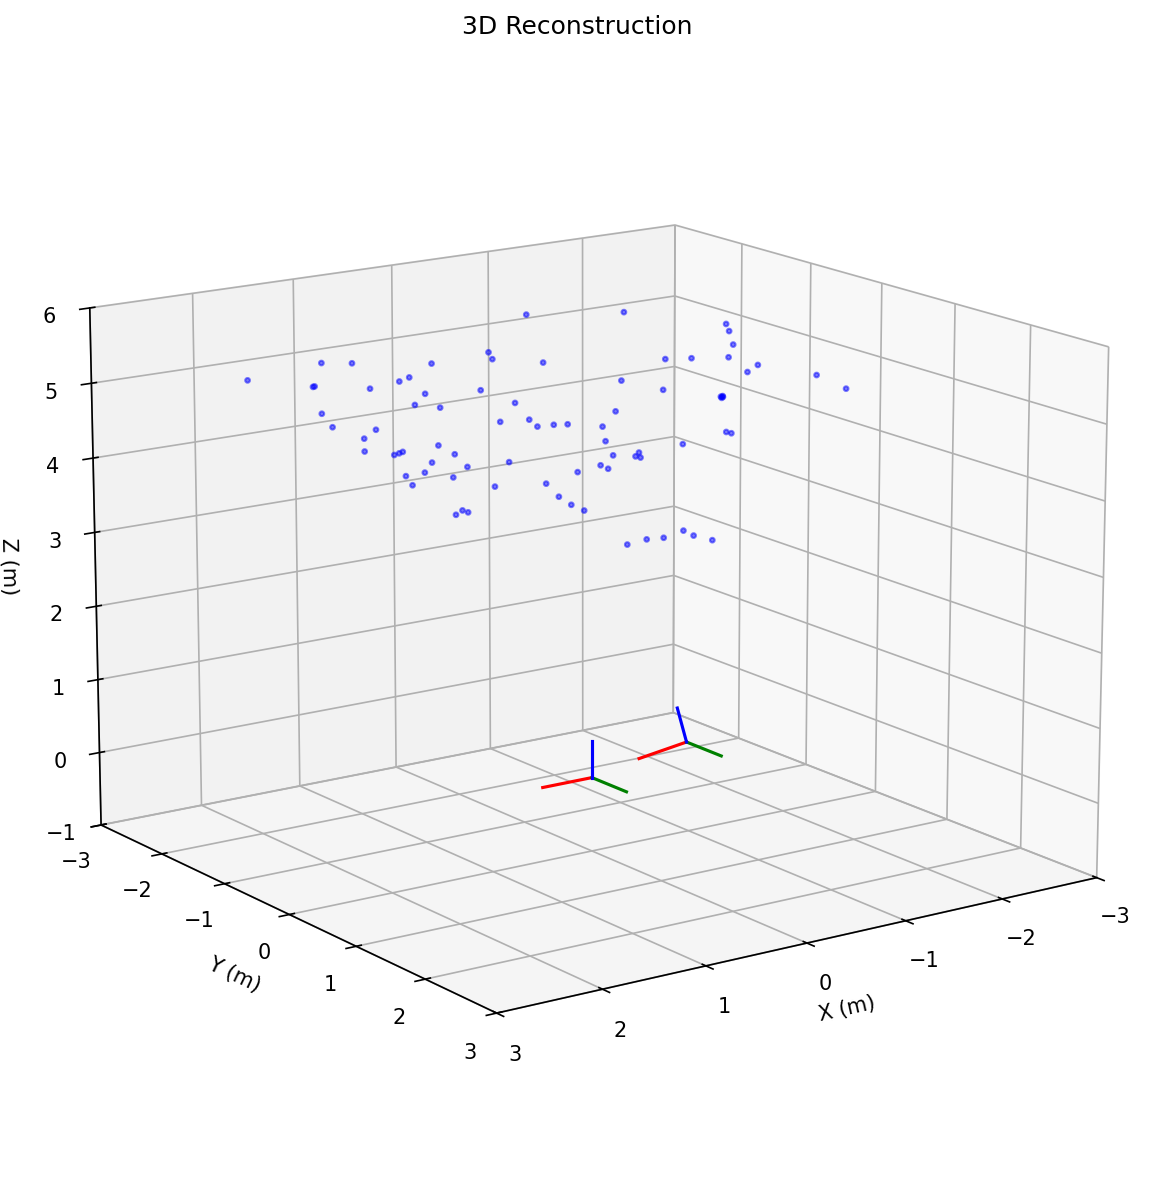

In [ ]:
fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Plotting 3D points
ax.scatter(P[0,:], P[1,:], P[2,:], c='b', s=5, alpha=0.5)

# camera frame
draw_frame(ax, np.eye(3), np.zeros((3,1)), length=0.5)
draw_frame(ax, R_correct, T_correct, length=0.5)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-1, 6)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Reconstruction')

ax.view_init(elev=15, azim=55)  # Changing view to adjust as needed

plt.tight_layout()
plt.savefig('prob2.png', bbox_inches='tight', dpi=300)
plt.show()

## How to Submit

Add
1. `prob2.png`

to your commit and push it to github.